Camera Matrix:
 [[745.60428046   0.         358.25258459]
 [  0.         586.77508202 113.59760473]
 [  0.           0.           1.        ]]
Reproj Error (pixels): 1.9791
[[729.90979431   0.         392.78925272]
 [  0.         586.77508202 113.59760473]
 [  0.           0.           1.        ]]


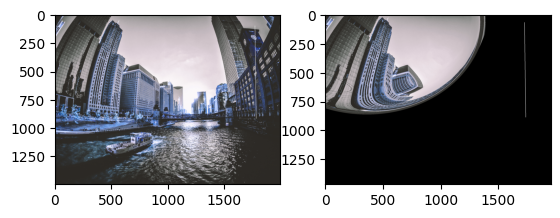

In [31]:
import numpy as np
import cv2 as cv
import glob
import os 
import matplotlib.pyplot as plt 

def calibrate(showPics=True):
    # Read Image
    root = os.getcwd()
    calibrationDir = os.path.join(root,'imageess')
    imgPathList = glob.glob(os.path.join(calibrationDir,'*.jpg'))

    # Initialize  
    nRows = 7 
    nCols = 7 
    termCriteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,30,0.001)
    worldPtsCur = np.zeros((nRows*nCols,3), np.float32)
    worldPtsCur[:,:2] = np.mgrid[0:nRows,0:nCols].T.reshape(-1,2)
    worldPtsCur *= 20
    #print(worldPtsCur)
    worldPtsList = []
    imgPtsList = [] 

    # Find Corners 
    for curImgPath in imgPathList:
        imgBGR = cv.imread(curImgPath)
        imgGray = cv.cvtColor(imgBGR, cv.COLOR_BGR2GRAY)
        cornersFound, cornersOrg = cv.findChessboardCorners(imgGray,(nRows,nCols), None)

        if cornersFound == True:
            worldPtsList.append(worldPtsCur)
            cornersRefined = cv.cornerSubPix(imgGray,cornersOrg,(11,11),(-1,-1),termCriteria)
            imgPtsList.append(cornersRefined)

            if showPics: 
                cv.drawChessboardCorners(imgBGR,(nRows,nCols),cornersRefined,cornersFound)
                cv.imshow('Chessboard', imgBGR)
                cv.waitKey(500)
    cv.destroyAllWindows()

    # Calibrate 
    repError,camMatrix,distCoeff,rvecs,tvecs = cv.calibrateCamera(worldPtsList, imgPtsList, imgGray.shape[::-1],None,None)
    print('Camera Matrix:\n',camMatrix)
    print("Reproj Error (pixels): {:.4f}".format(repError))
    
    # Save Calibration Parameters (later video)
    #curFolder = os.path.dirname(os.path.abspath(__file__))
    curFolder = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
    paramPath = os.path.join(curFolder,'calibratioon.npz')
    np.savez(paramPath, 
        repError=repError, 
        camMatrix=camMatrix, 
        distCoeff=distCoeff, 
        rvecs=rvecs, 
        tvecs=tvecs)
    
    return camMatrix,distCoeff

def removeDistortion(camMatrix,distCoeff): 
    root = os.getcwd()
    imgPath = os.path.join(root,'a.jpg')
    img = cv.imread(imgPath)
    
    height,width = img.shape[:2]
    camMatrixNew,roi = cv.getOptimalNewCameraMatrix(camMatrix,distCoeff,(width,height),1,(width,height)) # function helps optimize the camera matrix
    print(camMatrixNew)
    imgUndist = cv.undistort(img,camMatrix,distCoeff,None,camMatrixNew)
    x, y, w, h = roi
    imgUndistCropped = imgUndist[y:y+h, x:x+w]
    

    # Draw Line to See Distortion Change 
    cv.line(img,(1769,103),(1780,922),(255,255,255),2)
    cv.line(imgUndist,(1769,103),(1780,922),(255,255,255),2)

    plt.figure() 
    plt.subplot(121)
    plt.imshow(img)
    #plt.subplot(122)
    #plt.imshow(imgUndist)
    plt.subplot(122)
    plt.imshow(imgUndistCropped)
    plt.show()

def runCalibration(): 
    calibrate(showPics=True) 

def runRemoveDistortion(): 
    camMatrix,distCoeff = calibrate(showPics=False) 
    removeDistortion(camMatrix,distCoeff) 

if __name__ == '__main__': 
    #runCalibration() 
    runRemoveDistortion() 

In [20]:
import numpy as np 
import os 
import cv2 as cv 
import glob 
from enum import Enum

class DrawOption(Enum):
    AXES = 1
    CUBE = 2

def drawAxes(img,corners,imgpts):
    def tupleOfInts(arr):
        return tuple(int(x) for x in arr)

    corner = tupleOfInts(corners[0].ravel())
    img = cv.line(img,corner,tupleOfInts(imgpts[0].ravel()),(255,0,0),5)
    img = cv.line(img,corner,tupleOfInts(imgpts[1].ravel()),(0,255,0),5)
    img = cv.line(img,corner,tupleOfInts(imgpts[2].ravel()),(0,0,255),5)
    return img

def drawCube(img,imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # Add green plane 
    img = cv.drawContours(img,[imgpts[:4]],-1,(0,255,0),-3) # fisrt 4 down is fill

    # Add box borders  
    for i in range(4):
        j = i + 4
        img = cv.line(img,tuple(imgpts[i]),tuple(imgpts[j]),(255),3)
        img = cv.drawContours(img,[imgpts[4:]],-1,(0,0,255),3)
    return img 

def poseEstimation(option: DrawOption):
    # Retreive calibration parameters (from previous video)
    root = os.getcwd() 
    paramPath = os.path.join(root,'calibratioon.npz')
    data = np.load(paramPath)
    camMatrix = data['camMatrix']
    distCoeff = data['distCoeff']

    # Obtain image paths 
    calibrationDir = os.path.join(root,'imageess')
    imgPathList = glob.glob(os.path.join(calibrationDir,'*.jpg'))

    # Initialize  
    nRows = 7 
    nCols = 7
    termCriteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,30,0.001)
    worldPtsCur = np.zeros((nRows*nCols,3), np.float32)
    worldPtsCur[:,:2] = np.mgrid[0:nRows,0:nCols].T.reshape(-1,2)
    worldPtsCur*=20
    
    # World points of objects to be drawn 
    axis = np.float32([[3,0,0],[0,3,0],[0,0,-3]])
    cubeCorners = np.float32([[0,0,0],[0,3,0],[3,3,0],[3,0,0],
                       [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3]])
    
    # Find corners 
    for curImgPath in imgPathList:
        imgBGR = cv.imread(curImgPath)
        imgGray = cv.cvtColor(imgBGR, cv.COLOR_BGR2GRAY)
        cornersFound, cornersOrg = cv.findChessboardCorners(imgGray,(nRows,nCols),None)

        if cornersFound == True:
            cornersRefined = cv.cornerSubPix(imgGray,cornersOrg,(11,11),(-1,-1),termCriteria)
            _,rvecs,tvecs = cv.solvePnP(worldPtsCur,cornersRefined,camMatrix,distCoeff) #to estimate the pose (rotation and translation vectors) of the chessboard in the image.

            if option == DrawOption.AXES: 
                imgpts,_ = cv.projectPoints(axis,rvecs,tvecs,camMatrix,distCoeff)
                print("imgpts",imgpts)
                imgBGR = drawAxes(imgBGR,cornersRefined,imgpts)

            if option == DrawOption.CUBE:
                imgpts,_ = cv.projectPoints(cubeCorners,rvecs,tvecs,camMatrix,distCoeff) 
                imgBGR = drawCube(imgBGR,imgpts)
   
            cv.imshow('Chessboard',imgBGR)
            cv.waitKey(5000)

if __name__ == '__main__': 
    #poseEstimation(DrawOption.AXES) 
    poseEstimation(DrawOption.CUBE) 

In [1]:
from enum import Enum

class Color(Enum):
    RED = 1
    GREEN = 2
    BLUE = 3

print(Color.RED)  # Output: Color.RED
print(Color.RED.value)  # Output: 1

# Iterating over enum values
for color in Color:
    print(color)

# Comparison
if Color.GREEN == Color.BLUE:
    print("Colors are the same")
else:
    print("Colors are different")


Color.RED
1
Color.RED
Color.GREEN
Color.BLUE
Colors are different


In [2]:
from enum import Enum

class Color(Enum):
    RED = 1
    GREEN = 2
    BLUE = 3

def print_color(color):
    if color == Color.RED:
        print("The color is red.")
    elif color == Color.GREEN:
        print("The color is green.")
    elif color == Color.BLUE:
        print("The color is blue.")

print_color(Color.RED)  # Output: The color is red.


The color is red.


In [10]:
a = [[[283.3283 , 201.88295]]]
a[0]  #.ravel() flattens this list into a 1D array, resulting in [10, 20]

[[283.3283, 201.88295]]

In [1]:
pwd

'C:\\Users\\amb\\Downloads\\images\\sign-language-detection'

In [3]:
import cv2
import mediapipe as mp
import numpy as np

# Load calibration data
calib_data = np.load("calib_data/MultiMatrix.npz")
mtx = calib_data["camMatrix"]
dist = calib_data["distCoef"]

# Initialize MediaPipe Face Detection and Facial Landmark Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

# Function to draw axes on the nose
def draw_axes(image, nose_3d):
    # Length of the axes
    axis_length = 50

    # Origin point (nose)
    origin_point = tuple(nose_3d.astype(int))

    # End points of axes
    end_points = {
        "X": (origin_point[0] + int(axis_length), origin_point[1]),
        "Y": (origin_point[0], origin_point[1] + int(axis_length)),
        "Z": (origin_point[0], origin_point[1])
    }

    # Draw axes
    cv2.line(image, origin_point, end_points["X"], (0, 0, 255), 2)  # Red: X-axis
    cv2.line(image, origin_point, end_points["Y"], (0, 255, 0), 2)  # Green: Y-axis
    cv2.line(image, origin_point, end_points["Z"], (255, 0, 0), 2)  # Blue: Z-axis

    return image







# Function to estimate head pose with origin on nose
def estimate_head_pose(image, camera_matrix, distortion_coefficients):
    with mp_face_detection.FaceDetection(
        min_detection_confidence=0.5
    ) as face_detection, mp_face_mesh.FaceMesh(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
    ) as face_mesh:
        # Convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Detect faces in the image
        results = face_detection.process(image_rgb)
        
        if results.detections:
            # Extract face landmarks
            landmarks = face_mesh.process(image_rgb).multi_face_landmarks[0].landmark
            
            # Get nose landmark (index 2)
            nose_landmark = landmarks[2]
            nose_x = int(nose_landmark.x * image.shape[1])
            nose_y = int(nose_landmark.y * image.shape[0])
            
            # Project nose landmark to 3D using camera matrix and distortion coefficients
            nose_3d = cv2.projectPoints(np.array([[0, 0, 0]], dtype=np.float64), np.zeros((3, 1)), np.zeros((3, 1)), camera_matrix, distortion_coefficients)[0][0][0]

            # Draw origin point on nose
            cv2.circle(image, (nose_x, nose_y), 5, (0, 255, 0), -1)
            
            # Draw text indicating nose landmark
            cv2.putText(image, 'Nose', (nose_x, nose_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            return nose_3d

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    # Read frame from webcam
    ret, frame = cap.read()
    if not ret:
        break

    # Perform head pose estimation
    nose_3d = estimate_head_pose(frame, mtx, dist)

    if nose_3d is not None:
        # Draw axes on the nose
        frame = draw_axes(frame, nose_3d)

    # Display the result
    cv2.imshow("Head Pose Estimation", frame)

    # Check for key press
    key = cv2.waitKey(1)
    if key == ord("q"):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


TypeError: 'NoneType' object is not subscriptable

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5,min_tracking_confidence=0.5)
drawing_spec = mp_drawing.DrawingSpec(thickness=2,circle_radius=2,color=(255,0,255))

cap = cv2.VideoCapture(0)

while True:
    # Read frame from webcam
    start = time.time()
    success, image = cap.read()
    image = cv2.resize(image,(1200,800))
    
    image = cv2.cvtColor(cv2.flip(image,1),cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = face_mesh.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image , cv2.COLOR_RGB2BGR)

    img_h , img_w , img_c = image.shape
    
    face_3d = []
    face_2d = []

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx , lm in enumerate(face_landmarks.landmark):
                if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                    if idx == 1:
                        nose_2d = (lm.x*img_w , lm.y*img_h)
                        nose_3d = (lm.x*img_w , lm.y*img_h , lm.z*3000)
                        #print("lm.z",lm.z)
                        #print("lm.z",lm.z*3000)

                    x , y = int(lm.x*img_w) , int(lm.y*img_h)
                    face_2d.append([x,y])
                    face_3d.append([x,y,lm.z])
                        
            face_2d = np.array(face_2d , dtype=np.float64)
            face_3d = np.array(face_3d , dtype=np.float64)


            focal_length = 1 * img_w
            cam_matrix = np.array([[focal_length , 0 , img_h / 2],
                                  [0 , focal_length , img_w / 2],
                                  [0 , 0 , 1 ]])
            
            dist_matrix = np.zeros((4,1) , dtype=np.float64)
            success , rot_vec , trans_vec = cv2.solvePnP(face_3d , face_2d , cam_matrix , dist_matrix)

            rmat , jac = cv2.Rodrigues(rot_vec)

            angles , mtxR , mtxQ , Qx , Qy , Qz = cv2.RQDecomp3x3(rmat)  #into an upper triangular matrix (mtxR) and an orthogonal matrix (mtxQ), such that rmat = mtxR * mtxQ.

            x = angles[0] * 360
            y = angles[1] * 360
            z = angles[2] * 360

            if y < -10:
                text = "looking left"
            elif y > 7:
                text = "looking Right"
            elif x < -10:
                text = "looking Down"
            elif x > 10:
                text = "looking Up"    
            else:
                text = "forward"
                
            nose_3d = cv2.projectPoints(nose_3d , rot_vec , trans_vec , cam_matrix , dist_matrix)

            p1 = (int(nose_2d[0]) , int(nose_2d[1]))
            p2 = (int(nose_2d[0] + y * 10), int(nose_2d[1] - x * 10))
            cv2.line(image , p1 , p2 , (255,0,0) , 3)

            cv2.putText(image, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 2 , (0, 255, 0), 2)      
            cv2.putText(image, 'x: ' + str(np.round(x,2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 0, 255), 2)
            cv2.putText(image, 'y: ' + str(np.round(y,2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 0, 255), 2)
            cv2.putText(image, 'z: ' + str(np.round(z,2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 0, 255), 2)

            end = time.time()
            totalTime = end - start
            fps = 1/totalTime
            print('FPS' , fps)
            cv2.putText(image, f'FPS: {int(fps)}', (20, 250), cv2.FONT_HERSHEY_SIMPLEX, 1.5 , (0, 255, 0), 2) 

            mp_drawing.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec)
            
        # Display the result
        cv2.imshow("Head Pose Estimation", image)

        # Check for key press
        key = cv2.waitKey(1)
        if key == ord("q"):
            break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()   

    
    

FPS 14.501170312440577
FPS 7.434086200081886
FPS 18.878974469770625
FPS 17.867338027749025
FPS 18.87948434025621
FPS 18.880674145164484
FPS 6.2535376743118105
FPS 23.269757610390187
FPS 20.012233583189797
FPS 18.87880451906198
FPS 24.40563721211698
FPS 24.4050691834146
FPS 13.340449420333647
FPS 20.845301698217295
FPS 17.867261914904493
FPS 24.405211188111323
FPS 10.64444201940427
FPS 21.75164266414973
FPS 14.501420994765484
FPS 13.34023726980694
FPS 13.342910859655095
FPS 9.906525456555217
FPS 10.758874016919501
FPS 12.053567528421826
FPS 10.421640854641817
FPS 12.988477200588372
FPS 14.293663397378662
FPS 11.619536249549824
FPS 8.214992351640431
FPS 9.17959537420445
FPS 12.82783383134181
FPS 8.55193281286
FPS 8.265631928172647
FPS 11.10867918531663
FPS 14.074751176166602
FPS 12.433793514382016
FPS 12.507056701107782
FPS 13.167027682030225
FPS 13.896660603470268
FPS 13.706383103875352
FPS 13.336292499594599
FPS 12.507168587036904
FPS 13.006884404033888
FPS 10.532445062740598
FPS 12.99

In [2]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_objectron = mp.solutions.objectron

cap = cv2.VideoCapture(0)

# {'Shoe', 'Chair', 'Cup', 'Camera'}.
def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)


with mp_objectron.Objectron(static_image_mode=False,
                            max_num_objects=1,
                            min_detection_confidence=0.3,
                            min_tracking_confidence=0.3,
                            model_name='Cup') as objectron:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = objectron.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.detected_objects:
            print("Object Detected")
            for detected_object in results.detected_objects:
                mp_drawing.draw_landmarks(image, detected_object.landmarks_2d, mp_objectron.BOX_CONNECTIONS)
                mp_drawing.draw_axis(image, detected_object.rotation, detected_object.translation)
                
        cv2.imshow('3D OBJECT TRACKING - MediaPipe Objectron', rescale_frame(image, percent=150))
        key = cv2.waitKey(1)
        if key == ord("q"):
            break
cap.release()
cv2.destroyAllWindows()   

In [2]:
pwd

'C:\\Users\\amb\\Downloads\\images\\sign-language-detection'